In [57]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import cooler
import cooltools
from coolpuppy import coolpup
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker
import seaborn as sns
import numpy as np
from scipy.stats import wilcoxon, false_discovery_control
from os import listdir, system, path
import re
import bioframe as bf
from joblib import Memory
from sklearn.cluster import KMeans
import warnings
import utils
import pickle as pkl


warnings.filterwarnings("ignore", category=FutureWarning)

# Add cache functionality to some functions
cachedir = 'cache'
memory = Memory(cachedir, verbose=0)
expected_cis_cache = memory.cache(cooltools.expected_cis, ignore=['nproc'])
expected_trans_cache = memory.cache(cooltools.expected_trans, ignore=['nproc'])
subt_snips_cache = memory.cache(utils.subt_snips, ignore=['print_ct'])

# Set color palette
palette = {
    "EN": "#6451ca", 
    "IN": "#d1289e", 
    "NN": "#ffd18c",
    '2T': "#f3ffbd", 
    '3T': "#b2dbbf",
    'infant': "#70c1b3",
    'adult': "#247ba0"
}

# Set matplotlib settings
mpl.rc('lines', linewidth=0.4)
mpl.rc('font', family='Helvetica', size=8)
mpl.rc('axes', labelsize=8, titlesize=8, linewidth=0.4)
mpl.rc('legend', fontsize=8)
mpl.rc('xtick', labelsize=6)
mpl.rc('xtick.major', width=0.4, size=2)
mpl.rc('xtick.minor', width=0.4, size=1)
mpl.rc('ytick', labelsize=6)
mpl.rc('ytick.major', width=0.4, size=2)
mpl.rc('ytick.minor', width=0.4, size=1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Input data and parameters

In [28]:
# INPUT DATA

# Annotation of PcG contact anchors in adult neurons
hand_anch_path = "/tank/projects/polycomb/data/polycomb_dot_anchors.5kb.16_06_25.csv"

# PCA loadings
pca_loads_path = "/tank/projects/nvaulin_hic_sch/tian_polycomb_analysis/For_paper_Nov2024start/Polycomb_Loops_PCA_Loadings.csv"

# H3K27me3 ChIP-seq peaks and chromHMM
me3_path = {
    "IN": "/tank/projects/schizophrenia_2021/data/kozlenkov2018/H3K27me3/broadPeak/"\
          "GABA_REP1_peaks.flt.broadPeak.gz",
    "EN": "/tank/projects/schizophrenia_2021/data/kozlenkov2018/H3K27me3/broadPeak/"\
          "GLU_REP1_peaks.flt.broadPeak.gz",
    "fetal": "/tank/projects/schizophrenia_2021/data/rahman2023/fetal_ChromHMM_rgb.bed"
}

# Coolers
clr_dir = '/tank/projects/polycomb/data/heffel/mcools/'
clr_path = {
    "RG-1": "CTX.RG-1.2T.3056_cells.10kb.mcool",
    "RG-1_samp": "CTX.RG-1.2T.590_cells.10kb.mcool",
    "RG-2": "CTX.RG-2.2T.590_cells.10kb.mcool",
    "Astro_adult": "CTX.Astro.adult.559_cells.all.10kb.mcool",
    "Neu_adult_samp": "CTX.Exc_Inh.adult.590_cells.10kb.mcool",
    "Neu_2T": "CTX.Exc_Inh.2T.3056_cells.10kb.mcool",
    "Neu_3T": "CTX.Exc_Inh.3T.3056_cells.5kb.mcool",
    "Neu_infant": "CTX.Exc_Inh.infant.3056_cells.10kb.mcool",
    "Neu_adult": "CTX.Exc_Inh.adult.3056_cells.10kb.mcool",
    "EN_2T": "CTX.Exc.2T.728_cells.10kb.mcool",
    "EN_3T": "CTX.Exc.3T.728_cells.10kb.mcool",
    "EN_infant": "CTX.Exc.infant.728_cells.10kb.mcool",
    "EN_adult": "CTX.Exc.adult.728_cells.10kb.mcool",
    # "EN_2T": "CTX.Exc.2T.2176_cells.all.10kb.mcool",
    # "EN_3T": "CTX.Exc.3T.2176_cells.all.10kb.mcool",
    # "EN_infant": "CTX.Exc.infant.2176_cells.all.10kb.mcool",
    # "EN_adult": "CTX.Exc.adult.2176_cells.all.10kb.mcool",
    "IN_2T": "CTX.Inh.2T.728_cells.10kb.mcool",
    "IN_3T": "CTX.Inh.3T.728_cells.10kb.mcool",
    "IN_infant": "CTX.Inh.infant.728_cells.10kb.mcool",
    "IN_adult": "CTX.Inh.adult.728_cells.10kb.mcool",
    "EN_GW18": "CTX.Exc.2T.438_cells.20210224_GW18.10kb.mcool",
    "EN_GW20a": 'CTX.Exc.2T.749_cells.20210224_GW20a.10kb.mcool',
    'EN_GW20b': 'CTX.Exc.2T.1175_cells.20210224_GW20b.10kb.mcool',
    'EN_GW23': 'CTX.Exc.2T.467_cells.20210224_GW23.10kb.mcool',
    'EN_GW35': 'CTX.Exc.3T.1271_cells.20210316_UMB4267.10kb.mcool',
    'EN_GW39': 'CTX.Exc.3T.905_cells.20210316_UA1822.10kb.mcool',
    'EN_4mon': 'CTX.Exc.infant.1522_cells.20210316_UA1922.10kb.mcool',
    'EN_7mon': 'CTX.Exc.infant.806_cells.20191219_7mo.10kb.mcool',
    'EN_21yr': 'CTX.Exc.adult.726_cells.20210505_UMB5577.10kb.mcool',
    'EN_29yr': 'CTX.Exc.adult.1154_cells.20210505_UMB6096.10kb.mcool',
    'EN_37yr': 'CTX.Exc.adult.553_cells.20210528_UMB5621.10kb.mcool',
    "IN_GW18": "CTX.Inh.2T.170_cells.20210224_GW18.10kb.mcool",
    "IN_GW20a": 'CTX.Inh.2T.454_cells.20210224_GW20a.10kb.mcool',
    'IN_GW20b': 'CTX.Inh.2T.745_cells.20210224_GW20b.10kb.mcool',
    'IN_GW23': 'CTX.Inh.2T.625_cells.20210224_GW23.10kb.mcool',
    'IN_GW35': 'CTX.Inh.3T.363_cells.20210316_UMB4267.10kb.mcool',
    'IN_GW39': 'CTX.Inh.3T.641_cells.20210316_UA1822.10kb.mcool',
    'IN_4mon': 'CTX.Inh.infant.259_cells.20210316_UA1922.10kb.mcool',
    'IN_7mon': 'CTX.Inh.infant.469_cells.20191219_7mo.10kb.mcool',
    'IN_21yr': 'CTX.Inh.adult.472_cells.20210505_UMB5577.10kb.mcool',
    'IN_29yr': 'CTX.Inh.adult.420_cells.20210505_UMB6096.10kb.mcool',
    'IN_37yr': 'CTX.Inh.adult.205_cells.20210528_UMB5621.10kb.mcool',
}

"""
scRNA-seq data (Herring et al.)
"""
# Gene activity at PcG anchors
noex_path = "/tank/projects/schizophrenia_2021/results/2023.11.13/polycomb_dot_anchors.with_noex.csv"

# Pseudobulk counts 
pb_df_path = '/tank/projects/schizophrenia_2021/results/2023.11.13/herring_pseudobulk.csv.gz'

# Mean gene expression at 4 timepoints 
expr_dir = "/tank/projects/schizophrenia_2021/results/2023.11.13/"
heff_expr_path = {
    ct: expr_dir + f"Herring_expr_for_Heffel_stages.{ct}.log1p_CPM.csv"
    for ct in ['PN', 'IN']
}

In [29]:
# PARAMETERS

# Cooler matrix resolutions
clr_ress = [50_000, 100_000]

# Prepare data for analysis

In [30]:
# Read coolers
samps = list(clr_path.keys()) # cell types
clrs = {res: {samp: cooler.Cooler(clr_dir + clr_path[samp] + f'::resolutions/{res}') 
        for samp in samps} for res in clr_ress}

In [31]:
# Get genomic view to use with cooltools and coolpuppy
hg38_chromsizes = bf.fetch_chromsizes('hg38')
hg38_chromsizes_view = pd.DataFrame(data={'chrom': hg38_chromsizes.index, 
                                          'start': 0*len(hg38_chromsizes),
                                          'end': hg38_chromsizes.values,
                                          'name': hg38_chromsizes.index})
# Drop chrX, chrY, chrM
hg38_chromsizes_view = hg38_chromsizes_view\
    .loc[~hg38_chromsizes_view['name'].isin(['chrX', 'chrY', 'chrM'])]

In [32]:
# Load PcG contact annotation from adult neurons
hand_anch = pd.read_csv(hand_anch_path)
hand_anch = bf.sort_bedframe(hand_anch, hg38_chromsizes_view)

# If no gene overlaps anchor, assign unique index
n_nan = sum(hand_anch['genes'].isna())
hand_anch.loc[hand_anch['genes'].isna(), 'genes'] = [f"locus_{i}" for i in range(n_nan)]

# If anchors appear within 'res' from each other, merge anchors into one
hand_anch_d = {}
for res in clr_ress:
    hand_anch_d[res] = hand_anch.copy()
    hand_anch_d[res].loc[:, 'mid_start'] = (hand_anch_d[res]['start'] + hand_anch_d[res]['end']) / 2 \
        - ((hand_anch_d[res]['start'] + hand_anch_d[res]['end']) / 2) % res
    hand_anch_d[res].loc[:, 'mid_end'] = hand_anch_d[res]['mid_start'] + res
    hand_anch_d[res].loc[:, 'mid_start'] = hand_anch_d[res].loc[:, 'mid_start'].astype(int)
    hand_anch_d[res].loc[:, 'mid_end'] = hand_anch_d[res].loc[:, 'mid_end'].astype(int)
    
    
    hand_anch_d[res] = hand_anch_d[res].drop(columns=['start', 'end'])\
        .groupby(['chrom', 'mid_start', 'mid_end'], as_index=False)\
        .agg({'genes': lambda x: ','.join(x)})\
        .reset_index(drop=True)\
        .rename(columns={'mid_start': 'start', 'mid_end': 'end'})\
        .loc[:, ['chrom', 'start', 'end', 'genes']]
    hand_anch_d[res][['start', 'end']] = hand_anch_d[res][['start', 'end']].astype(int)

hand_anch_d[clr_ress[0]].head()

,chrom,start,end,genes
0,chr1,18600000,18650000,PAX7
1,chr1,24900000,24950000,RUNX3
2,chr1,44400000,44450000,RNF220
3,chr1,46450000,46500000,locus_0
4,chr1,47200000,47250000,"TAL1,AL135960.1"


In [33]:
# Extract gene names at PcG anchors
hand_genes_all = hand_anch['genes'].dropna().str.split(',').values
hand_genes_all = [item for sublist in hand_genes_all for item in sublist]

# remove transcripts and ncRNAs
regex = re.compile(r'(^LINC|^RNA|^MIR|^A[LCP][0-9]+|.*\-AS|.*\-DT|.*\-OT)')
hand_pc = [i for i in hand_genes_all if not regex.match(i)]
hand_pc[:5]

['PAX7', 'RUNX3', 'RNF220', 'locus_0', 'TAL1']

In [34]:
# Separate anchors into two groups, active (noex=False) and inactive (noex=True), 
# based on expression of genes at the anchors
noex = pd.read_csv(noex_path, na_values='no_gene')

# Take into account that anchors within the same resolution bin are merged
# and assign noex value correctly
for res in clr_ress:
    hand_anch_d[res] = bf.overlap(hand_anch_d[res], noex, how='inner')\
        .groupby(['chrom', 'start', 'end', 'genes'], as_index=False)['noex_']\
        .all()\
        .rename(columns={'noex_': 'noex'})
hand_anch_d[clr_ress[0]].head()

,chrom,start,end,genes,noex
0,chr1,18600000,18650000,PAX7,False
1,chr1,24900000,24950000,RUNX3,True
2,chr1,44400000,44450000,RNF220,False
3,chr1,46450000,46500000,locus_0,True
4,chr1,47200000,47250000,"TAL1,AL135960.1",True


# Plot: example region from 5 Hi-C maps of neuronal development

In [22]:
res = 100_000
pl_clrs = {
    "RG-1": clrs[res]["RG-1"],
    "2T": clrs[res]['Neu_2T'],
    "3T": clrs[res]['Neu_3T'],
    "infant": clrs[res]['Neu_infant'],
    "adult": clrs[res]['Neu_adult'],
}
pl_grps = list(pl_clrs.keys())

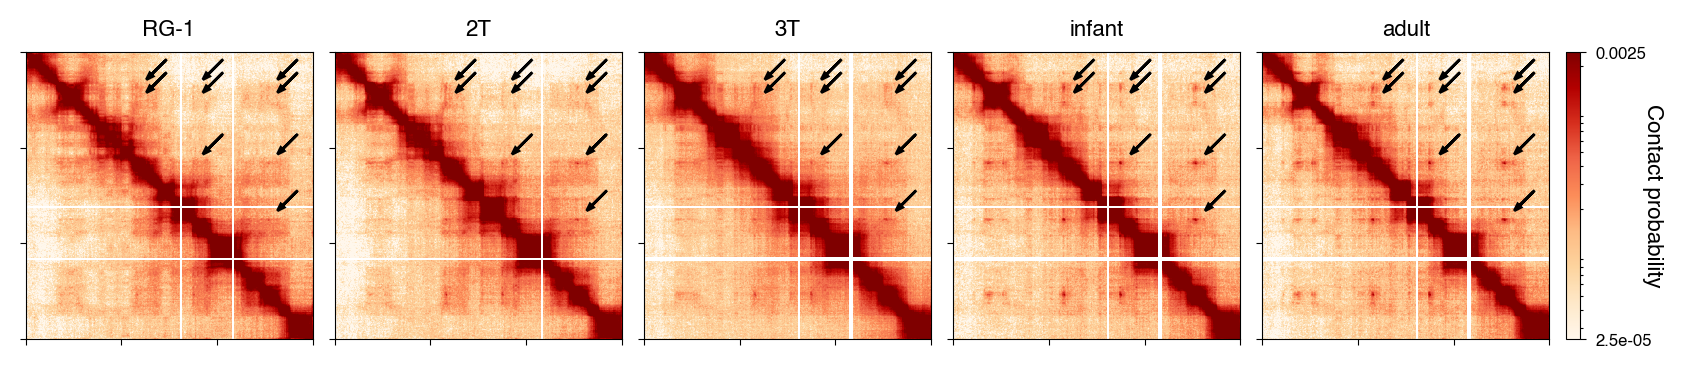

In [23]:
# Draw heatmaps
plot_reg = ('chr1', 40_000_000, 100_000_000)
vmin, vmax = 0.000025, 0.0025 # 100kb res
wr = [1] * len(pl_grps)
wr.append(0.05)
regs2annot = [[63_320_000, 47_710_000],
              [63_320_000, 50_430_000],
              [75_120_000, 47_710_000],
              [75_120_000, 50_430_000],
              [75_120_000, 63_320_000],
              [90_720_000, 47_710_000],
              [90_720_000, 50_430_000],
              [90_720_000, 63_320_000],
              [90_720_000, 75_120_000]]
arr_offset = 3_000_000
f, axs = plt.subplots(1, len(pl_grps) + 1, dpi=200, figsize=(8.3, 4), 
                      constrained_layout=True, width_ratios=wr)

for i, grp in enumerate(pl_grps):
    ax = axs[i]
    im = utils.plot_hic_reg_zoom_out(
        pl_clrs[grp], 
        reg=plot_reg, 
        ax=ax, 
        vmin=vmin, 
        vmax=vmax, 
        title=grp,
        cbar=False,
        cmap='OrRd'
    )
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    for reg in regs2annot:
        ax.arrow(reg[0] + 2*arr_offset, reg[1] - 2*arr_offset, 
                 -arr_offset, arr_offset, width=1e4, head_width=1e6, fc='k')

# Draw colorbar
ax = axs[len(pl_grps)]
cb = plt.colorbar(im, cax=ax, 
             ticks=[vmin, vmax], 
             orientation='vertical',
             format=ticker.FuncFormatter(lambda x, pos: f"{x:.2g}"))
cb.ax.set_ylabel('Contact probability', rotation=270, fontsize=8)
ax.set_box_aspect(20)

# plt.savefig("heffel_5maps_neur_dev.pdf")

# Average dots and boxplots

Average dots & boxplots (by window = True):

- EN-IN at 4 stages (same number of cells) - 50kb
- EN-IN by samples - 50 kb

Average dots:

- RG1-RG2-adult astrocytes-adult_neurons - 50kb
- neuronal RG and all neurons at 4 stages and at 3 distance ranges - 50kb
- neuronal RG and all neurons at 4 stages divided into "silent" and "active" - 50kb

## Plot: EN-IN at 4 stages

Average dot & boxplots

In [24]:
# Select required coolers
res = 50_000
pl_clrs = {
    'EN': {
        "2T": clrs[res]['EN_2T'],
        "3T": clrs[res]['EN_3T'],
        "infant": clrs[res]['EN_infant'],
        "adult": clrs[res]['EN_adult'],
    },
    'IN': {
        "2T": clrs[res]['IN_2T'],
        "3T": clrs[res]['IN_3T'],
        "infant": clrs[res]['IN_infant'],
        "adult": clrs[res]['IN_adult'],
    },
}
pl_cts, pl_ages = ['EN', 'IN'], ['2T', '3T', 'infant', 'adult']

In [25]:
# Expected
pl_cvd = {ct: {} for ct in pl_cts}
nproc = 10
for ct in pl_cts:
    for age in pl_ages:
        print(ct, age)
        pl_cvd[ct][age] = expected_cis_cache(
            pl_clrs[ct][age],
            view_df=hg38_chromsizes_view,
            smooth=True,
            nproc=nproc
        )

EN 2T
EN 3T
EN infant
EN adult
IN 2T
IN 3T
IN infant
IN adult


In [26]:
# Pileup
by_window = True
features = hand_anch_d[res]
nproc=15

# Split by distance
pl_pups = {ct: {} for ct in pl_cts}
for ct in pl_cts:
    for age in pl_ages:
        print(ct, age)
        pl_pups[ct][age] = coolpup.pileup(
            pl_clrs[ct][age],
            features,
            view_df=hg38_chromsizes_view,
            expected_df=pl_cvd[ct][age],
            flank=15 * res,
            mindist=int(3e6),
            by_window=by_window,
            nproc=nproc
        );

EN 2T


INFO:coolpuppy:('chr14', 'chr14'): 44
INFO:coolpuppy:('chr13', 'chr13'): 96
INFO:coolpuppy:('chr9', 'chr9'): 148
INFO:coolpuppy:('chr11', 'chr11'): 98
INFO:coolpuppy:('chr12', 'chr12'): 44
INFO:coolpuppy:('chr15', 'chr15'): 40
INFO:coolpuppy:('chr8', 'chr8'): 102
INFO:coolpuppy:('chr7', 'chr7'): 220
INFO:coolpuppy:('chr10', 'chr10'): 220
INFO:coolpuppy:('chr6', 'chr6'): 520
INFO:coolpuppy:('chr3', 'chr3'): 86
INFO:coolpuppy:('chr4', 'chr4'): 290
INFO:coolpuppy:('chr5', 'chr5'): 514
INFO:coolpuppy:('chr1', 'chr1'): 434
INFO:coolpuppy:('chr2', 'chr2'): 826
Process ForkPoolWorker-9:
Process ForkPoolWorker-13:
Process ForkPoolWorker-12:
Process ForkPoolWorker-10:
Process ForkPoolWorker-14:
Process ForkPoolWorker-11:
Process ForkPoolWorker-2:
Process ForkPoolWorker-6:
Process ForkPoolWorker-5:
Process ForkPoolWorker-3:
Process ForkPoolWorker-8:
Process ForkPoolWorker-7:
Process ForkPoolWorker-4:
Process ForkPoolWorker-15:
Process ForkPoolWorker-1:
Traceback (most recent call last):
Tracebac

KeyboardInterrupt: 

INFO:coolpuppy:('chr15', 'chr15'): 2214
INFO:coolpuppy:('chr20', 'chr20'): 5638
INFO:coolpuppy:('chr18', 'chr18'): 476
INFO:coolpuppy:('chr8', 'chr8'): 3492
INFO:coolpuppy:('chr13', 'chr13'): 620
INFO:coolpuppy:('chr19', 'chr19'): 6290
INFO:coolpuppy:('chr14', 'chr14'): 4204
INFO:coolpuppy:('chr9', 'chr9'): 3586
INFO:coolpuppy:('chr11', 'chr11'): 6920
INFO:coolpuppy:('chr17', 'chr17'): 11248
INFO:coolpuppy:('chr5', 'chr5'): 6172
INFO:coolpuppy:('chr6', 'chr6'): 3442
INFO:coolpuppy:('chr16', 'chr16'): 8562
INFO:coolpuppy:('chr12', 'chr12'): 8828
INFO:coolpuppy:('chr7', 'chr7'): 5802
INFO:coolpuppy:('chr10', 'chr10'): 6200
INFO:coolpuppy:('chr4', 'chr4'): 3956
INFO:coolpuppy:('chr2', 'chr2'): 7640
INFO:coolpuppy:('chr3', 'chr3'): 11784
INFO:coolpuppy:('chr21', 'chr21'): 40
INFO:coolpuppy:('chr22', 'chr22'): 768
INFO:coolpuppy:('chr1', 'chr1'): 38316
INFO:coolpuppy:Total number of piled up windows: 146198
INFO:coolpuppy:('chr14', 'chr14'): 198
INFO:coolpuppy:('chr21', 'chr21'): 216
INFO:c

In [ ]:
utils.plot_av_dot_2d(pl_pups, 4)

In [ ]:
# Prepare dataframe for boxplots
n_dots = pl_pups[pl_cts[0]][pl_ages[0]].shape[0]
n_cts, n_ages = len(pl_cts), len(pl_ages)
cent_vals = np.empty((n_dots, n_cts * n_ages), dtype=float)

j=0
for ct in pl_cts:
    for age in pl_ages:
        arr = pl_pups[ct][age]['data'].to_list()
        for i, snip in enumerate(arr):
            cent_vals[i, j] = snip[snip.shape[0] // 2, snip.shape[1] // 2]
        j+=1

pup_df_cols = pd.MultiIndex.from_product([pl_cts, pl_ages], names=['ct', 'age'])
pup_df = pd.DataFrame(data=cent_vals, columns=pup_df_cols).dropna()
pup_df.head()

In [ ]:
# Boxplots
plt.figure(dpi=200, figsize=[2, 1.5])
plot_df = pup_df.melt()
sns.boxplot(data=plot_df, 
            x='ct', 
            y='value', 
            hue='age', 
            showfliers=False, 
            linewidth=0.4, 
            gap=0,
            palette=palette,
            saturation=1, 
           )
plt.ylabel('Dot intensity (obs./exp.)')
plt.xlabel('')
plt.legend(fontsize=6)
plt.grid(axis='y', alpha=0.6, linewidth=0.4)
plt.tight_layout()
# plt.savefig("boxplot_dot_instensity_EN_IN.pdf")

In [ ]:
# Calculate significance for boxplots
for ct in ['EN', 'IN']:
    print(
        ct, wilcoxon(pup_df[(ct, '2T')], pup_df[(ct, '3T')]).pvalue, '\n',
        ct, wilcoxon(pup_df[(ct, '3T')], pup_df[(ct, 'infant')]).pvalue, '\n',
        ct, wilcoxon(pup_df[(ct, 'infant')], pup_df[(ct, 'adult')]).pvalue, '\n',
    )

## Plot: EN-IN by samples

In [ ]:
# Select required coolers
res = 50_000
pl_clrs = {
    'EN': {
        "GW18": clrs[res]['EN_GW18'],
        "GW20a": clrs[res]['EN_GW20a'],
        "GW20b": clrs[res]['EN_GW20b'],
        "GW23": clrs[res]['EN_GW23'],
        "GW35": clrs[res]['EN_GW35'],
        "GW39": clrs[res]['EN_GW39'],
        "4mon": clrs[res]['EN_4mon'],
        "7mon": clrs[res]['EN_7mon'],
        "21yr": clrs[res]['EN_21yr'],
        "29yr": clrs[res]['EN_29yr'],
        "37yr": clrs[res]['EN_37yr'],
    },
    'IN': {
        "GW18": clrs[res]['IN_GW18'],
        "GW20a": clrs[res]['IN_GW20a'],
        "GW20b": clrs[res]['IN_GW20b'],
        "GW23": clrs[res]['IN_GW23'],
        "GW35": clrs[res]['IN_GW35'],
        "GW39": clrs[res]['IN_GW39'],
        "4mon": clrs[res]['IN_4mon'],
        "7mon": clrs[res]['IN_7mon'],
        "21yr": clrs[res]['IN_21yr'],
        "29yr": clrs[res]['IN_29yr'],
        "37yr": clrs[res]['IN_37yr'],
    },
}
pl_grps1 = list(pl_clrs.keys())
pl_grps2 = list(pl_clrs[pl_grps1[0]].keys())

In [ ]:
# Expected
warnings.filterwarnings("ignore", category=FutureWarning)


pl_cvd = {grp1: {} for grp1 in pl_grps1}
nproc = 10
for grp1 in pl_grps1:
    for grp2 in pl_grps2:
        print(grp1, grp2)
        pl_cvd[grp1][grp2] = expected_cis_cache(
            pl_clrs[grp1][grp2],
            view_df=hg38_chromsizes_view,
            smooth=True,
            nproc=nproc
        )

In [ ]:
# Pileup
by_window = True
features = hand_anch_d[res]
nproc=15

# Split by distance
pl_pups = {grp1: {} for grp1 in pl_grps1}
for grp1 in pl_grps1:
    for grp2 in pl_grps2:
        print(grp1, grp2)
        pl_pups[grp1][grp2] = coolpup.pileup(
            pl_clrs[grp1][grp2],
            features,
            view_df=hg38_chromsizes_view,
            expected_df=pl_cvd[grp1][grp2],
            flank=15 * res,
            mindist=int(3e6),
            by_window=by_window,
            nproc=nproc
        );

In [ ]:
utils.plot_av_dot_2d(pl_pups, 4)

In [ ]:
# Prepare dataframe for boxplots
n_dots = pl_pups[pl_grps1[0]][pl_grps2[0]].shape[0]
n_grps1, n_grps2 = len(pl_grps1), len(pl_grps2)
cent_vals = np.empty((n_dots, n_grps1 * n_grps2), dtype=float)

j=0
for grp1 in pl_grps1:
    for grp2 in pl_grps2:
        arr = pl_pups[grp1][grp2]['data'].to_list()
        for i, snip in enumerate(arr):
            cent_vals[i, j] = snip[snip.shape[0] // 2, snip.shape[1] // 2]
        j+=1

pup_df_cols = pd.MultiIndex.from_product([pl_grps1, pl_grps2], names=['ct', 'age'])
pup_df = pd.DataFrame(data=cent_vals, columns=pup_df_cols).dropna()
pup_df.head()

In [ ]:
# Boxplots
plt.figure(dpi=200, figsize=[3, 1.75])
plot_df = pup_df.melt()
sns.boxplot(data=plot_df, 
            x='age', 
            y='value', 
            hue='ct', 
            showfliers=False, 
            linewidth=0.4, 
            palette=palette,
            saturation=1, 
           )
plt.ylabel('Dot intensity (obs./exp.)')
plt.xlabel('Biological samples')
plt.xticks(rotation=20)
plt.legend(fontsize=6)
plt.grid(axis='y', alpha=0.6, linewidth=0.4)
plt.tight_layout()
# plt.savefig("boxplot_dot_instensity_EN_IN_reps.pdf")

In [ ]:
# Calculate significance for boxplots
pvals = []
for grp in pl_grps2:
    p = wilcoxon(pup_df[('EN', grp)], pup_df[('IN', grp)]).pvalue
    pvals.append(p)

for grp in pl_grps1:
    p = wilcoxon(pup_df[(grp, 'GW18')], pup_df[(grp, 'GW35')]).pvalue
    pvals.append(p)
    p = wilcoxon(pup_df[(grp, 'GW20a')], pup_df[(grp, 'GW35')]).pvalue
    pvals.append(p)
    p = wilcoxon(pup_df[(grp, 'GW39')], pup_df[(grp, '4mon')]).pvalue
    pvals.append(p)

# FDR correction
padj = false_discovery_control(pvals)
padj

## Plot: RG1-RG2-adult astrocytes-adult_neurons

In [ ]:
# Select required coolers
res = 50_000
pl_clrs = {
    'Neu': {
        "RG": clrs[res]["RG-1_samp"],
        "adult": clrs[res]['Neu_adult_samp'],
    },
    'Astro': {
        "RG": clrs[res]['RG-2'],
        "adult": clrs[res]['Astro_adult'],
    },
}
pl_cts, pl_ages = ['Neu', 'Astro'], ['RG', 'adult']

In [ ]:
# Expected
warnings.filterwarnings("ignore", category=FutureWarning)


pl_cvd = {ct: {} for ct in pl_cts}
nproc = 10
for ct in pl_cts:
    for age in pl_ages:
        print(ct, age)
        pl_cvd[ct][age] = expected_cis_cache(
            pl_clrs[ct][age],
            view_df=hg38_chromsizes_view,
            smooth=False,
            nproc=nproc
        )

In [ ]:
# Pileup
by_window = False
features = hand_anch_d[res]
nproc=15

# Split by distance
pl_pups = {ct: {} for ct in pl_cts}
for ct in pl_cts:
    for age in pl_ages:
        print(ct, age)
        pl_pups[ct][age] = coolpup.pileup(
            pl_clrs[ct][age],
            features,
            view_df=hg38_chromsizes_view,
            expected_df=pl_cvd[ct][age],
            flank=15 * res,
            mindist=int(3e6),
            by_window=by_window,
            nproc=nproc
        );

In [ ]:
utils.plot_av_dot_2d(pl_pups, 5)

## Plot: neuronal RG and all neurons at 4 stages and at 3 distance ranges

In [ ]:
# Select required coolers
res = 50_000
pl_clrs = {
    "RG-1": clrs[res]["RG-1"],
    "2T": clrs[res]['Neu_2T'],
    "3T": clrs[res]['Neu_3T'],
    "infant": clrs[res]['Neu_infant'],
    "adult": clrs[res]['Neu_adult'],
}
pl_grps = list(pl_clrs.keys())

In [ ]:
# Expected
# cis
pl_cvd = {}
nproc = 10
for grp in pl_grps:
    print("cis", grp)
    pl_cvd[grp] = expected_cis_cache(
        pl_clrs[grp],
        view_df=hg38_chromsizes_view,
        smooth=False,
        nproc=nproc
    )

# trans
pl_cvd_trans = {}
for grp in pl_grps:
    print("trans", grp)
    pl_cvd_trans[grp] = expected_trans_cache(
        pl_clrs[grp],
        nproc=nproc
    )

In [ ]:
# Pileup
by_window = False
features = hand_anch_d[res]
nproc=15

# Split by distance
pl_pups = {'short': {}, 'long': {}, 'trans': {}}
for grp in pl_grps:
    print(grp)
    pl_pups['short'][grp] = coolpup.pileup(
        pl_clrs[grp],
        features,
        view_df=hg38_chromsizes_view,
        expected_df=pl_cvd[grp],
        flank=15 * res,
        mindist=3*res,
        maxdist=int(3e6),
        by_window=by_window,
        nproc=nproc
    );
    pl_pups['long'][grp] = coolpup.pileup(
        pl_clrs[grp],
        features,
        view_df=hg38_chromsizes_view,
        expected_df=pl_cvd[grp],
        flank=15 * res,
        mindist=int(3e6),
        by_window=by_window,
        nproc=nproc
    );
    pl_pups['trans'][grp] = coolpup.pileup(
        pl_clrs[grp],
        features,
        expected_df=pl_cvd_trans[grp],
        flank=15 * res,
        trans=True,
        by_window=by_window,
        nproc=nproc
    );

In [ ]:
utils.plot_av_dot_2d(pl_pups, 4)

## Plot: neuronal RG and all neurons at 4 stages divided into "silent" and "active"

In [ ]:
# Select required coolers
pl_clrs = {
    "RG-1": clrs[res]["RG-1"],
    "2T": clrs[res]['Neu_2T'],
    "3T": clrs[res]['Neu_3T'],
    "infant": clrs[res]['Neu_infant'],
    "adult": clrs[res]['Neu_adult'],
}
pl_grps = list(pl_clrs.keys())

In [ ]:
# Expected
pl_cvd = {}
nproc = 10
for grp in pl_grps:
    print(grp)
    pl_cvd[grp] = expected_cis_cache(
        pl_clrs[grp],
        view_df=hg38_chromsizes_view,
        smooth=False,
        nproc=nproc
    )

In [ ]:
# Pileup
by_window = False
nproc=15

# Split by distance
pl_pups = {'silent': {}, 'active': {}}
for grp in pl_grps:
    print(grp)
    pl_pups['silent'][grp] = coolpup.pileup(
        pl_clrs[grp],
        hand_anch_d[res].loc[hand_anch_d[res]['noex']],
        view_df=hg38_chromsizes_view,
        expected_df=pl_cvd[grp],
        flank=15 * res,
        mindist=int(3e6),
        by_window=by_window,
        nproc=nproc
    );
    pl_pups['active'][grp] = coolpup.pileup(
        pl_clrs[grp],
        hand_anch_d[res].loc[~hand_anch_d[res]['noex']],
        view_df=hg38_chromsizes_view,
        expected_df=pl_cvd[grp],
        flank=15 * res,
        mindist=int(3e6),
        by_window=by_window,
        nproc=nproc
    );

In [ ]:
utils.plot_av_dot_2d(pl_pups, 4)

# Dots with highest and lowest PCA loadings

In [35]:
# Select required coolers
res = 100_000
pl_clrs = {
    "EN_2T": clrs[res]['EN_2T'],
    "EN_3T": clrs[res]['EN_3T'],
    "EN_infant": clrs[res]['EN_infant'],
    "EN_adult": clrs[res]['EN_adult'],
    "IN_2T": clrs[res]['IN_2T'],
    "IN_3T": clrs[res]['IN_3T'],
    "IN_infant": clrs[res]['IN_infant'],
    "IN_adult": clrs[res]['IN_adult'],
}
pl_grps = list(pl_clrs.keys())

In [36]:
# Expected
pl_cvd = {}
nproc = 10
for grp in pl_grps:
    print(grp)
    pl_cvd[grp] = expected_cis_cache(
        pl_clrs[grp],
        view_df=hg38_chromsizes_view,
        smooth=False,
        nproc=nproc
    )

EN_2T
EN_3T
EN_infant
EN_adult
IN_2T
IN_3T
IN_infant
IN_adult


In [37]:
pca_load = utils.parse_pca_df(pca_loads_path)
pca_load.head(1)

,PC1,PC2,PC3,PC4,genes,gene1,gene2,chrom1,start1,end1,chrom2,start2,end2
"(('chr1', 18630000, 18640000), ('chr1', 24930000, 24940000))",0.046807,-0.019838,0.002143,-0.006629,PAX7 <-> RUNX3,PAX7,RUNX3,chr1,18630000,18640000,chr1,24930000,24940000


### Plot: PC1

In [38]:
# Extract regions (snippets) from contact matrix
pca_top = pd.concat([pca_load.nlargest(5, 'PC1'), 
                     pca_load.nsmallest(5, 'PC1')]).reset_index(drop=True)
pca_top = bf.sort_bedframe(pca_top, cols=['chrom1', 'start1', 'end1'], 
                           reset_index=False)

snips = subt_snips_cache(pca_top, pl_clrs, pl_cvd, hg38_chromsizes_view, nbin_flank=6)

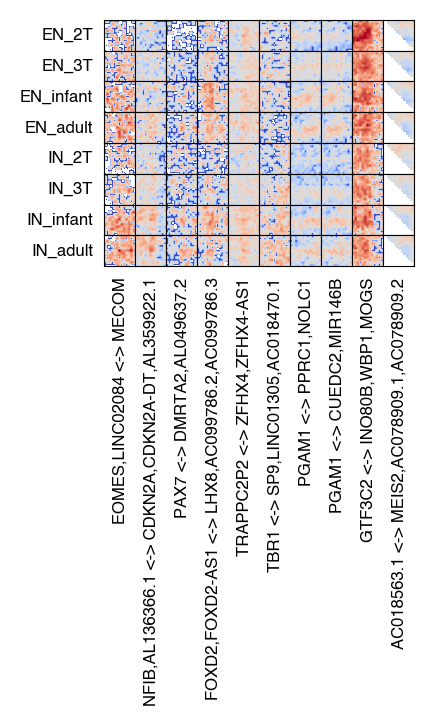

In [39]:
utils.plot_loads(pca_top, pl_grps, snips)
# plt.savefig('heffel.top_bottom_pca_dots.pc1.pdf', bbox_inches='tight')

### Plot: PC2

In [40]:
pca_top = pd.concat([pca_load.nlargest(5, 'PC2'), 
                     pca_load.nsmallest(5, 'PC2')]).reset_index(drop=True)
pca_top = bf.sort_bedframe(pca_top, cols=['chrom1', 'start1', 'end1'], 
                           reset_index=False)

snips = subt_snips_cache(pca_top, pl_clrs, pl_cvd, hg38_chromsizes_view, nbin_flank=6)

EN_2T
EN_3T
EN_infant
EN_adult
IN_2T
IN_3T
IN_infant
IN_adult


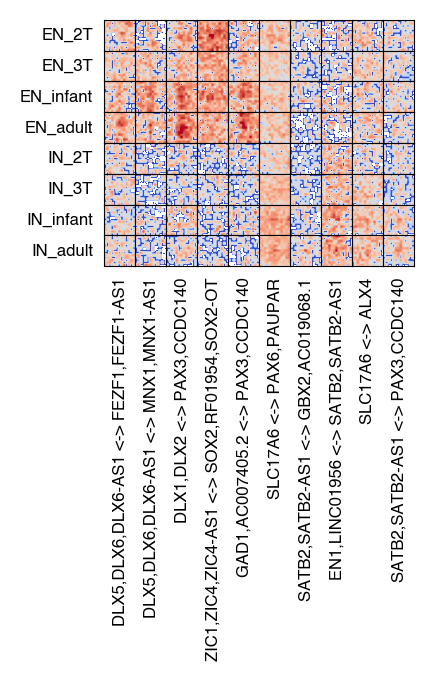

In [41]:
utils.plot_loads(pca_top, pl_grps, snips)
# plt.savefig('heffel.top_bottom_pca_dots.pc2.pdf', bbox_inches='tight')

# Fetal H3K27me3

Assuming that there are long-range PcG contacts in fetal neurons that are absent from adult neurons, take unique fetal H3K27me3 ChIP-seq peaks and extract contact frequencies from all pairs of such regions. Compare the resulting frequency distribution with distribution obtained when using adult-only H3K27me3 peaks.

Since PcG contacts in adult neurons anchor large H3K27me3 peaks (> 10kb), for fetal data, we also consider only large peaks

There are no publicly available peaks for fetal sample, instead, we use regions from chromHMM annotation

In [42]:
# Select required coolers
res = 100_000
pl_clrs = {
    "2T": clrs[res]['Neu_2T'],
    "3T": clrs[res]['Neu_3T'],
    "infant": clrs[res]['Neu_infant'],
    "adult": clrs[res]['Neu_adult'],
}
pl_grps1 = list(pl_clrs.keys())
pl_grps2 = ['fet', 'adu']

In [43]:
# Expected
pl_cvd = {}
nproc = 10
for grp in pl_grps1:
    print(grp)
    pl_cvd[grp] = expected_cis_cache(
        pl_clrs[grp],
        view_df=hg38_chromsizes_view,
        smooth=False,
        nproc=nproc
    )

2T
3T
infant
adult


In [44]:
# Read H3K27me3 peaks
grps = list(me3_path.keys())
me3_df = {
    grp: bf.read_table(path, schema='narrowPeak').drop(columns='relSummit')
    for grp, path in me3_path.items()
}

# Keep only H3K27me3-associted regions in chromHMM
me3_df['fetal'] = me3_df['fetal'].loc[me3_df['fetal']['name'].isin(['ReprPC', 'TssBiv'])]

for grp in grps:
    print("N peaks:", grp, me3_df[grp].shape[0])
    
me3_df[grps[0]].head()

N peaks: IN 156744
N peaks: EN 185251
N peaks: fetal 75777


,chrom,start,end,name,score,strand,fc,-log10p,-log10q
0,chr1,664863,665135,GABA_REP1_peak_1,12,.,2.96305,3.20213,1.23661
1,chr1,887357,888294,GABA_REP1_peak_2,21,.,3.55056,4.45904,2.15745
2,chr1,889968,890512,GABA_REP1_peak_3,14,.,2.98475,3.49629,1.44463
3,chr1,927078,927540,GABA_REP1_peak_4,10,.,2.60157,2.72587,1.00659
4,chr1,933161,933444,GABA_REP1_peak_5,10,.,2.81331,2.94974,1.08779


In [45]:
# Select adult peaks NOT present in fetal neurons
adu_only = pd.concat([me3_df['EN'], me3_df['IN']], ignore_index=True)
adu_only = bf.setdiff(adu_only, me3_df['fetal'])
adu_only = bf.merge(adu_only)
adu_only['size'] = adu_only['end'] - adu_only['start']

# Keep large peaks
adu_only = adu_only.loc[adu_only['size'] >= 10_000].reset_index(drop=True)
print("N peaks:", adu_only.shape[0])
adu_only.head()

# Get bins from intervals
me3_bins = {}
me3_bins['adu'] = utils.regs_to_bins(adu_only, res, mode='all', return_index=False)\
    .drop_duplicates(subset=['chrom', 'start', 'end'])\
    .reset_index(drop=True)
me3_bins['adu'] = bf.trim(me3_bins['adu'], hg38_chromsizes_view).dropna()
print("N bins:", me3_bins['adu'].shape[0])
me3_bins['adu'].head()

N peaks: 452
N bins: 287


,chrom,start,end,n_intervals,size
0,chr1,113200000.0,113300000.0,1,10530
1,chr1,143500000.0,143600000.0,2,14708
2,chr1,143600000.0,143700000.0,1,21391
3,chr1,161400000.0,161500000.0,3,14040
4,chr1,228500000.0,228600000.0,5,10128


In [46]:
# Select fetal peaks NOT present in adult neurons (EN or IN)
fet_only = bf.setdiff(me3_df['fetal'], me3_df['EN'])
fet_only = bf.setdiff(fet_only, me3_df['IN'])
fet_only = bf.merge(fet_only)
fet_only['size'] = fet_only['end'] - fet_only['start']

# Keep large peaks
fet_only = fet_only.loc[fet_only['size'] >= 10_000].reset_index(drop=True)
print("N peaks:", fet_only.shape[0])

# Get bins from intervals
me3_bins['fet'] = utils.regs_to_bins(fet_only, res, mode='all', return_index=False)\
    .drop_duplicates(subset=['chrom', 'start', 'end'])\
    .reset_index(drop=True)
me3_bins['fet'] = bf.trim(me3_bins['fet'], hg38_chromsizes_view).dropna()
print("N bins:", me3_bins['fet'].shape[0])
me3_bins['fet'].head()

N peaks: 2908
N bins: 1672


,chrom,start,end,n_intervals,size
0,chr1,800000.0,900000.0,2,12400
1,chr1,900000.0,1000000.0,4,18800
2,chr1,1100000.0,1200000.0,1,11800
3,chr1,1200000.0,1300000.0,5,10600
4,chr1,1500000.0,1600000.0,1,15600


In [47]:
# Pileup
by_window = True
nproc = 20

# Split by distance
pl_pups = {grp: {} for grp in pl_grps1}

for grp1 in pl_grps1:
    for grp2 in pl_grps2:
        print(grp1, grp2)
        pl_pups[grp1][grp2] = coolpup.pileup(
            pl_clrs[grp1],
            me3_bins[grp2],
            view_df=hg38_chromsizes_view,
            expected_df=pl_cvd[grp1],
            flank=0,
            mindist=int(3e6),
            by_window=by_window,
            nproc=nproc
        );

2T fet
2T adu
3T fet
3T adu
infant fet
infant adu
adult fet
adult adu


In [49]:
# Prepare dataframe for plotting
pup_df = {}
for grp2 in pl_grps2:
    n_dots = pl_pups[pl_grps1[0]][grp2].shape[0]
    n_grps1 = len(pl_grps1)
    cent_vals = np.empty((n_dots, n_grps1), dtype=float)
    
    for j, grp1 in enumerate(pl_grps1):
        arr = pl_pups[grp1][grp2]['data'].to_list()
        for i, snip in enumerate(arr):
            cent_vals[i, j] = snip[snip.shape[0] // 2, snip.shape[1] // 2]
    
    pup_df[grp2] = pd.DataFrame(data=cent_vals, columns=pl_grps1).dropna()
    pup_df[grp2] = pup_df[grp2].melt(var_name='snm3c_seq')
    pup_df[grp2]['me3'] = grp2

plot_df = pd.concat([pup_df[grp2] for grp2 in pl_grps2], ignore_index=True)
plot_df = plot_df.loc[plot_df['value'] > 0]

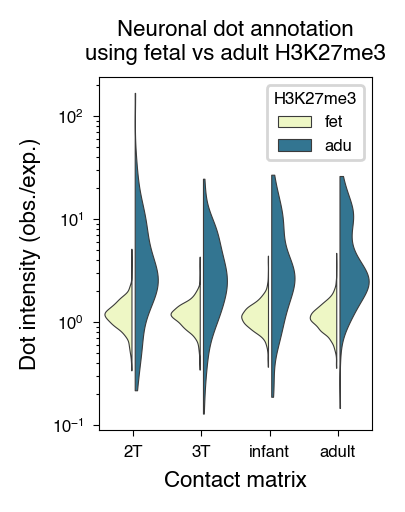

In [51]:
plt.figure(dpi=200, figsize=[2, 2.6])
palette = {
    'fet': "#f3ffbd", 
    'adu': "#247ba0"
}
sns.violinplot(data=plot_df, 
               x='snm3c_seq', 
               y='value', 
               hue='me3', 
               split=True, 
               gap=.1, 
               inner=None, 
               width=0.95, 
               log_scale=10, 
               linewidth=0.4,
               palette=palette,
               cut=0)
plt.ylabel('Dot intensity (obs./exp.)')
plt.xlabel('Contact matrix')
plt.legend(loc="upper right", fontsize=6, 
           title='H3K27me3', title_fontsize=6)
plt.title("Neuronal dot annotation\nusing fetal vs adult H3K27me3")
plt.tight_layout()
# plt.savefig("violin_fetal_vs_adult_dots.pdf")

# Run pyDESEQ2

In [58]:
# Read count data
pb_df = pd.read_csv(pb_df_path, index_col=0)
pb_df.head()

,ga22_PN,ga22_IN,ga24_PN,ga24_IN,ga34_PN,ga34_IN,118d_PN,118d_IN,179d_PN,179d_IN,20yr_PN,20yr_IN,25yr_PN,25yr_IN
RP11-34P13.7,32,1,22,1,21,2,28,14,3,1,45,9,47,18
AL627309.1,7,0,10,0,6,0,6,1,2,0,25,4,11,3
RP11-34P13.14,5,0,1,0,0,1,1,2,0,0,0,0,1,0
AP006222.2,648,59,618,34,138,25,680,317,178,102,448,191,479,301
RP4-669L17.10,312,41,349,29,837,131,412,129,236,67,616,283,325,159


In [59]:
# Create an object for DE analysis
pbulk = utils.Pb_de(pb_df, hand_pc)

## Fetal

In Herring et al. dataset, there is only one sample correspoding to 3T, therefore, we combined 2T and 3T timepoints into "fetal"

In [60]:
# Perform DE analysis
age = 'fetal'
pbulk.age_deseq2(age)

Fitting size factors...
... done in 0.01 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 6.26 seconds.

Fitting dispersion trend curve...
... done in 0.60 seconds.

Fitting MAP dispersions...
... done in 6.87 seconds.

Fitting LFCs...
... done in 4.66 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...


Log2 fold change & Wald test p-value: ct PN vs IN
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
RP11-34P13.7     6.130580        0.982299  1.038818  0.945593  0.344356   
AL627309.1       1.253781        2.122785  2.485354  0.854118  0.393040   
RP11-34P13.14    0.694217       -1.220861  2.663285 -0.458404  0.646662   
AP006222.2     124.173147        0.058740  0.543533  0.108070  0.913940   
RP4-669L17.10  204.533057        0.089874  0.864527  0.103958  0.917203   
...                   ...             ...       ...       ...       ...   
AL590523.1       0.873487       -1.111204  2.269410 -0.489644  0.624386   
PNRC2-1          5.939986        0.451065  1.023377  0.440762  0.659386   
SRSF10-1        80.609166       -0.270895  0.576757 -0.469687  0.638579   
AC145205.1      11.209818        1.375889  1.107226  1.242645  0.213999   
CU459201.1       2.187572        1.463669  1.916556  0.763697  0.445048   

                   padj  
RP11-34P13.7   0.999822

... done in 4.00 seconds.



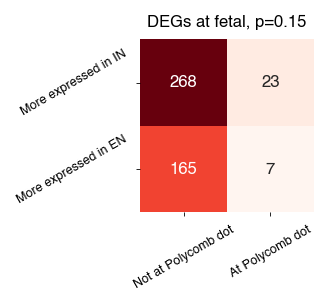

In [61]:
pbulk.cont_table(age)
pbulk.plot_cont(age)

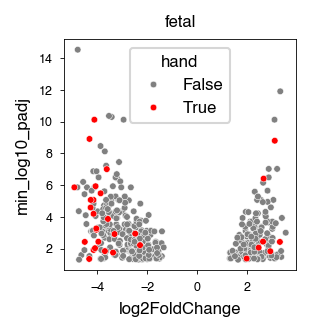

In [62]:
pbulk.plot_volc(age)

## Infant

In [63]:
age = 'infant'
pbulk.age_deseq2(age)

Fitting size factors...
... done in 0.01 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 6.02 seconds.

Fitting dispersion trend curve...
... done in 0.59 seconds.

/home/ipletenev/.conda/envs/cool/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 6.13 seconds.

Fitting LFCs...
... done in 4.73 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...


Log2 fold change & Wald test p-value: ct PN vs IN
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
RP11-34P13.7     6.961624       -0.004241  1.724311 -0.002460  0.998037   
AL627309.1       1.318138        1.773614  3.778436  0.469404  0.638781   
RP11-34P13.14    0.478504       -1.789065  5.020884 -0.356325  0.721597   
AP006222.2     251.822688       -0.254986  0.602519 -0.423201  0.672149   
RP4-669L17.10  179.317981        0.488300  0.672971  0.725589  0.468091   
...                   ...             ...       ...       ...       ...   
AL590523.1       0.097284        0.050921  5.421031  0.009393  0.992505   
PNRC2-1         11.140548        0.901563  1.385533  0.650697  0.515242   
SRSF10-1        89.345218       -0.227132  0.926128 -0.245249  0.806263   
AC145205.1      20.193668       -0.006863  1.073174 -0.006395  0.994898   
CU459201.1       2.439740       -0.553875  2.900729 -0.190944  0.848570   

                   padj  
RP11-34P13.7   0.999987

... done in 3.98 seconds.



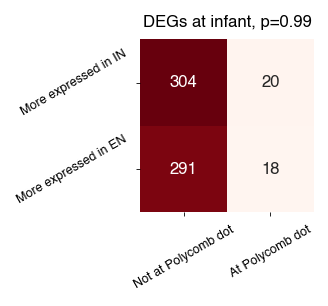

In [64]:
pbulk.cont_table(age)
pbulk.plot_cont(age)

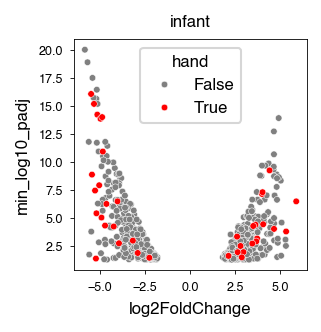

In [65]:
pbulk.plot_volc(age)

## Adult

In [66]:
age = 'adult'
pbulk.age_deseq2(age)

Fitting size factors...
... done in 0.01 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 5.35 seconds.

Fitting dispersion trend curve...
... done in 0.57 seconds.

/home/ipletenev/.conda/envs/cool/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 6.18 seconds.

Fitting LFCs...
... done in 4.35 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...


Log2 fold change & Wald test p-value: ct PN vs IN
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
RP11-34P13.7    25.770720        0.928536  0.714926  1.298786  0.194017   
AL627309.1       9.036196        1.480791  1.193543  1.240668  0.214729   
RP11-34P13.14    0.183130        0.570433  5.344360  0.106736  0.914999   
AP006222.2     333.367767        0.066246  0.317582  0.208594  0.834765   
RP4-669L17.10  326.746067        0.181057  0.422217  0.428826  0.668050   
...                   ...             ...       ...       ...       ...   
AL590523.1       1.960949       -2.131173  2.514343 -0.847606  0.396657   
PNRC2-1          9.226275        0.247796  1.189435  0.208331  0.834971   
SRSF10-1       120.007479       -0.143970  0.442862 -0.325089  0.745114   
AC145205.1      25.389272        1.261609  0.774180  1.629606  0.103185   
CU459201.1       2.032589        2.255134  2.654206  0.849646  0.395522   

                   padj  
RP11-34P13.7   0.689559

... done in 4.01 seconds.



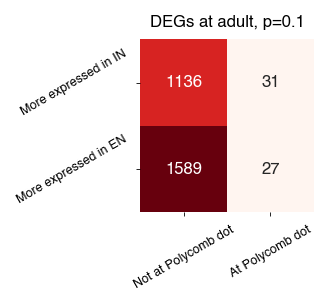

In [67]:
pbulk.cont_table(age)
pbulk.plot_cont(age)

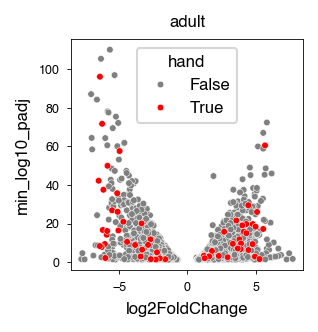

In [68]:
pbulk.plot_volc('adult')

## Plot: upsetplot of overlap between DE genes at different stages

Are there ("inconsistent") genes that are more more expressed in EN at one stage and more expressed in IN - at another stage?

In [69]:
ages = ['fetal', 'infant', 'adult']
res_df_mrg = pbulk.results_df[ages[0]].copy() # first one

if len(ages) < 2:
    raise ValueError("At least two ages required")
elif len(ages) == 2:
    res_df_mrg = res_df_mrg.join(pbulk.results_df[ages[1]], how='outer', 
                                 lsuffix=f'_{ages[0]}', rsuffix=f'_{ages[1]}')
else:
    for i in range(len(ages) - 2):
        res_df_mrg = res_df_mrg\
            .join(pbulk.results_df[ages[i+1]], how='outer', lsuffix=f'_{ages[i]}', rsuffix=f'_{ages[i+1]}')
    # last one
    last_pb = pbulk.results_df[ages[-1]].copy(deep=True).add_suffix(f'_{ages[-1]}') # for correct column names
    res_df_mrg = res_df_mrg.join(last_pb, how='outer')

for age in ages:
    res_df_mrg[f'signif_{age}'] = res_df_mrg[f'padj_{age}'] < 0.05
    res_df_mrg.loc[:, f'lfc_signif_{age}'] = res_df_mrg[f'signif_{age}'] * res_df_mrg.loc[:, f'lfc_sign_{age}']

res_df_de = res_df_mrg\
    .loc[res_df_mrg[f'hand_{ages[0]}'] & 
         np.any(res_df_mrg[[f'padj_{age}' for age in ages]] < 0.05, axis=1)]

en_de = np.any(res_df_de[[f'lfc_signif_{age}' for age in ages]].values == 1, axis=1)
in_de = np.any(res_df_de[[f'lfc_signif_{age}' for age in ages]].values == -1, axis=1)
incons_de = en_de & in_de
print("Number of inconsistent genes:", incons_de.sum())

Number of inconsistent hand genes: 0


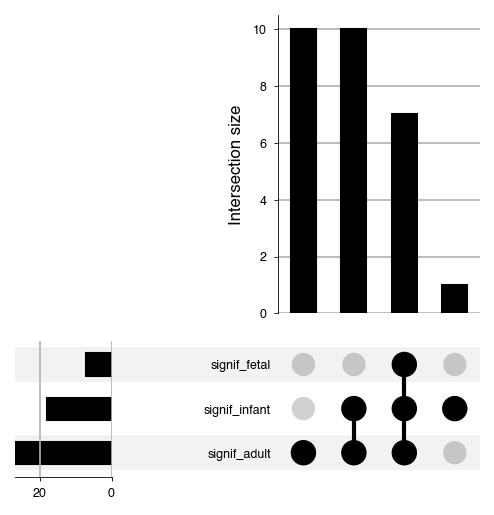

In [70]:
# EN
from upsetplot import plot

vc_en = res_df_de.loc[en_de, [f'signif_{age}' for age in ages]].value_counts()

fig = plt.figure(dpi=150)
plot(vc_en, sort_by="cardinality", sort_categories_by='-input', fig=fig);

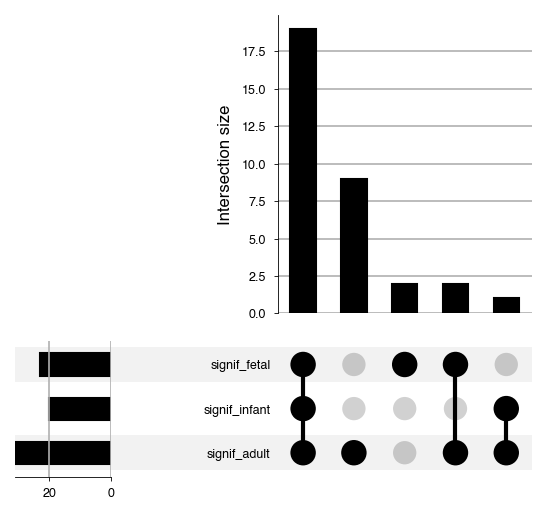

In [71]:
# IN
from upsetplot import plot

vc_in = res_df_de.loc[in_de, [f'signif_{age}' for age in ages]].value_counts()
fig = plt.figure(dpi=150)
plot(vc_in, sort_by="cardinality", sort_categories_by='-input', fig=fig);

## Plot: heatmap and boxplots for DE genes

In [72]:
# Load mean expression obtained from Herring et al.
heff_expr = {
    ct: pd.read_table(path, sep=',', index_col=0)
    for ct, path in heff_expr_path.items()
}
heff_expr['IN'].head()

,2T,3T,adult,infant,gene.id,highly_variable
RP11-34P13.7,0.258031,0.366954,0.767961,0.542424,ENSG00000238009,False
AL627309.1,0.000000,0.000000,0.262010,0.046894,ENSG00000237683,False
RP11-34P13.14,0.000000,0.200215,0.000000,0.091688,ENSG00000239906,False
AP006222.2,2.687074,1.878189,3.093464,3.050068,ENSG00000228463,False
RP4-669L17.10,2.425092,3.402471,2.991411,2.342789,ENSG00000237094,False


In [73]:
heff_expr_comb = heff_expr['PN'].join(heff_expr['IN'], how='inner', lsuffix='_EN', rsuffix='_IN')

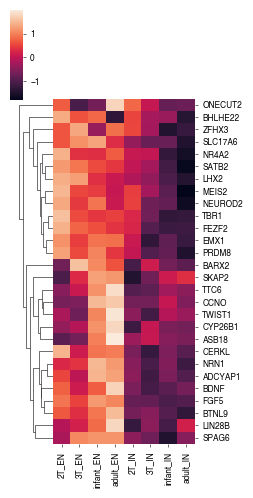

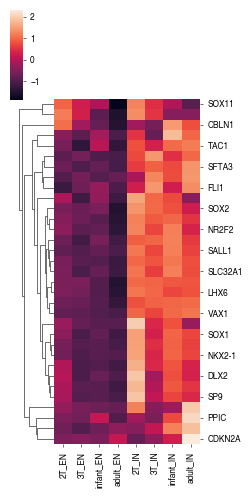

In [74]:
degs = {
    'EN': res_df_de.loc[en_de].index,
    'IN': res_df_de.loc[in_de].index,
    'all': res_df_de.loc[in_de].index.union(res_df_de.loc[en_de].index)
} 
expr_cols = ['2T_EN', '3T_EN', 'infant_EN', 'adult_EN', 
             '2T_IN', '3T_IN', 'infant_IN', 'adult_IN']

for i, ct in enumerate(['EN', 'IN']):
    heff_expr_z = heff_expr_comb.loc[degs[ct], expr_cols].copy(deep=True)
    heff_expr_z = heff_expr_z.sub(heff_expr_z.mean(axis=1), axis=0).div(heff_expr_z.std(axis=1), axis=0)
    sns.clustermap(heff_expr_z, col_cluster=False, figsize=(2.5, 5))
    # plt.savefig(f"heatmap_ages_degs.{ct}.pdf")

EN 0.14377250522375107 EN 0.003738619387149811 EN 0.6136380508542061 EN 0.18578492105007172 EN 0.03660209017913067 EN 0.17090606689453125 EN 0.014598868787288666 EN 0.0024397894740104675
IN 9.082956239581108e-06 IN 0.5134843902196735 IN 4.5744431572838726e-05 IN 2.935994416475296e-07 IN 0.0022327967453747988 IN 0.015230289660394192 IN 0.3214736534282565 IN 0.25653275568038225


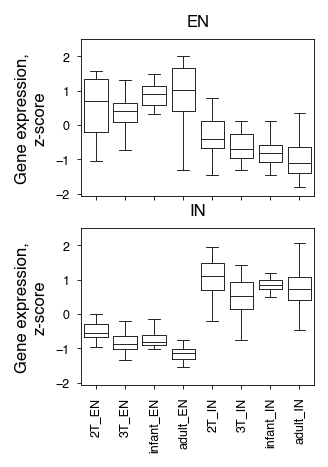

In [75]:
degs = {
    'EN': res_df_de.loc[en_de].index,
    'IN': res_df_de.loc[in_de].index,
    'all': res_df_de.loc[in_de].index.union(res_df_de.loc[en_de].index)
} 
expr_cols = ['2T_EN', '3T_EN', 'infant_EN', 'adult_EN', 
             '2T_IN', '3T_IN', 'infant_IN', 'adult_IN']

fig, axs = plt.subplots(2, 1, dpi=150, sharey=True, figsize=[2, 3], sharex=True)

for i, ct in enumerate(['EN', 'IN']):
    ax = axs[i]
    heff_expr_z = heff_expr_comb.loc[degs[ct], expr_cols].copy(deep=True)
    heff_expr_z = heff_expr_z.sub(heff_expr_z.mean(axis=1), axis=0).div(heff_expr_z.std(axis=1), axis=0)
    sns.boxplot(heff_expr_z, ax=ax, linewidth=0.4, fill=False, fliersize=0, color='black')
    ax.set_ylabel("Gene expression,\nz-score", fontsize=8)
    print(
        ct, wilcoxon(heff_expr_z['2T_EN'], heff_expr_z['3T_EN']).pvalue,
        ct, wilcoxon(heff_expr_z['3T_EN'], heff_expr_z['infant_EN']).pvalue,
        ct, wilcoxon(heff_expr_z['infant_EN'], heff_expr_z['adult_EN']).pvalue,
        ct, wilcoxon(heff_expr_z['2T_EN'], heff_expr_z['adult_EN']).pvalue,
        ct, wilcoxon(heff_expr_z['2T_IN'], heff_expr_z['3T_IN']).pvalue,
        ct, wilcoxon(heff_expr_z['3T_IN'], heff_expr_z['infant_IN']).pvalue,
        ct, wilcoxon(heff_expr_z['infant_IN'], heff_expr_z['adult_IN']).pvalue,
        ct, wilcoxon(heff_expr_z['2T_IN'], heff_expr_z['adult_IN']).pvalue,
    )
    ax.set_title(ct)
    ax.set_xticks(np.arange(len(expr_cols)), expr_cols, rotation=90, fontsize=6)

# plt.savefig('boxplot.gene_expr.age_degs.pdf')

## Calculate average loops for genes differentially expressed between EN and IN in any stage

Make pairs from DE genes and non-expressed genes

In [76]:
# Select required coolers
res = 100_000
pl_clrs = {
    "EN_2T": clrs[res]['EN_2T'],
    "EN_3T": clrs[res]['EN_3T'],
    "EN_infant": clrs[res]['EN_infant'],
    "EN_adult": clrs[res]['EN_adult'],
    "IN_2T": clrs[res]['IN_2T'],
    "IN_3T": clrs[res]['IN_3T'],
    "IN_infant": clrs[res]['IN_infant'],
    "IN_adult": clrs[res]['IN_adult'],
}
pl_grps = list(pl_clrs.keys())

In [77]:
# Expected
pl_cvd = {}
nproc = 10
for grp in pl_grps:
    print(grp)
    pl_cvd[grp] = expected_cis_cache(
        pl_clrs[grp],
        view_df=hg38_chromsizes_view,
        smooth=True,
        nproc=nproc
    )

EN_2T
EN_3T
EN_infant
EN_adult
IN_2T
IN_3T
IN_infant
IN_adult


In [78]:
hand_anch_d[res]['gene_lst'] = hand_anch_d[res]['genes'].str.split(',')
hand_anch_d[res]['de_EN'] = hand_anch_d[res]['gene_lst']\
    .apply(lambda gl: True if len([g for g in gl if g in degs['EN']]) > 0 else False)
hand_anch_d[res]['de_IN'] = hand_anch_d[res]['gene_lst']\
    .apply(lambda gl: True if len([g for g in gl if g in degs['IN']]) > 0 else False)

In [79]:
pair_sites = bf.pair_by_distance(
    hand_anch_d[res], min_sep=3_000_000, max_sep=int(1e10), suffixes=('1', '2'), 
)

In [80]:
pair_ct_noex = {
    ct: pair_sites.loc[(pair_sites['noex1'] & pair_sites[f'de_{ct}2']) | 
                       (pair_sites['noex2'] & pair_sites[f'de_{ct}1'])]
    for ct in ['EN', 'IN']
}

for ct in ['EN', 'IN']:
    print(pair_ct_noex[ct].shape)

(157, 16)
(174, 16)


In [81]:
# For all polycomb dot anchors
nproc=10

# Split by distance
pups_ct = {de_ct: {} for de_ct in ['EN', 'IN']}
for de_ct in ['EN', 'IN']:
    for grp in pl_grps:
        print(de_ct, grp)
        pups_ct[de_ct][grp] = coolpup.pileup(
            pl_clrs[grp],
            pair_ct_noex[de_ct],
            features_format='bedpe',
            view_df=hg38_chromsizes_view,
            expected_df=pl_cvd[grp],
            flank=4 * res,
            mindist=int(3e6),
            nproc=nproc
        );

EN EN_2T
EN EN_3T
EN EN_infant
EN EN_adult
EN IN_2T
EN IN_3T
EN IN_infant
EN IN_adult
IN EN_2T
IN EN_3T
IN EN_infant
IN EN_adult
IN IN_2T
IN IN_3T
IN IN_infant
IN IN_adult


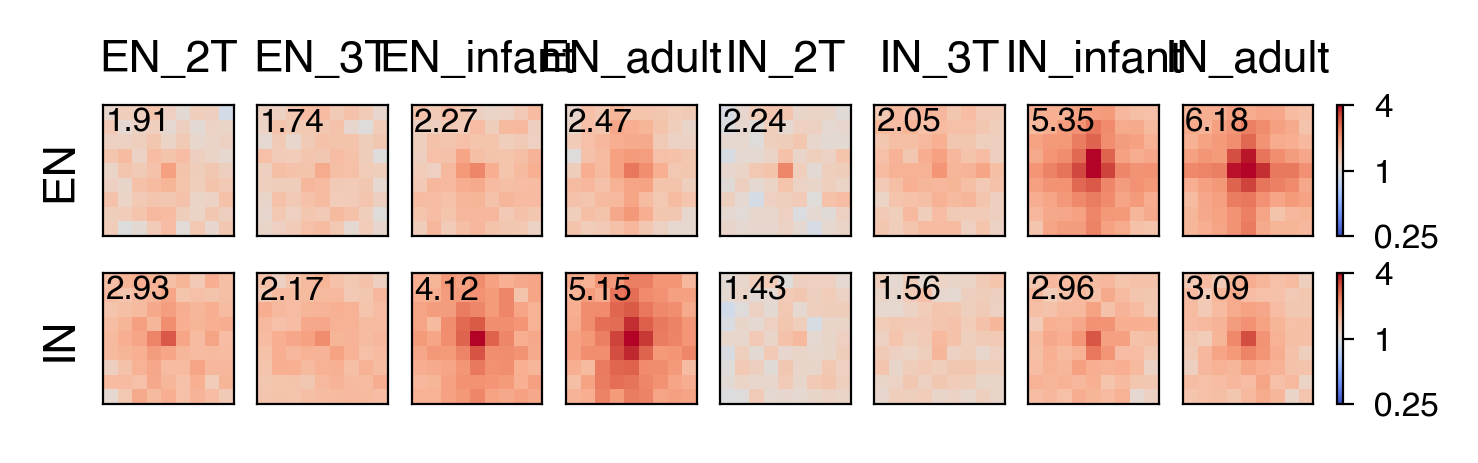

In [82]:
utils.plot_av_dot_2d(pups_ct, 4)